In [1]:
%%html
<img src="http://localhost:8888/files/img/pycon.png">

In [2]:
%%javascript
$(".repository-content, .container").css("width", "90%")
$("body, #outer-dashboard, .navbar-default").css("background-color", "peachpuff")
$(".navbar-default").css("background-color", "lightblue")

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline

In [4]:
import datetime
from math import pi

import matplotlib.pyplot as plt
import requests

import zmq
from zmq.eventloop.zmqstream import ZMQStream

from IPython.display import display
from ipywidgets import interact, widgets

from bokeh.io import push_notebook
from bokeh.models import ColumnDataSource
from bokeh.models import DatetimeTickFormatter, HoverTool
from bokeh.plotting import figure, show, output_notebook

from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

In [5]:
output_notebook(hide_banner=True);

In [21]:
url = r'http://2016.pyconuk.org/programme'
html = requests.get(url).text
soup = BeautifulSoup(html, 'html.parser')

In [52]:
def make_wordcloud(day):
    text = soup.find('div', id=day).text.lower()
    wc = WordCloud(stopwords=STOPWORDS | {'room', 'lesson'}, background_color='black', width=640,
                   height=320).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

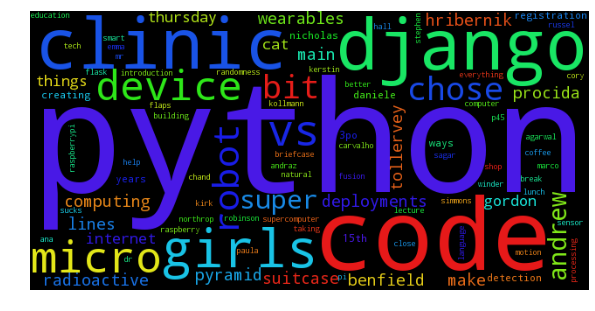

In [53]:
@interact(day=widgets.Dropdown(value=None, description='PyconUK Day', options=[None, 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday']))
def render(day):
    if day:
        make_wordcloud(day.lower())

In [ ]:
class LivePlot(object):
    PORT = 5556

    def __init__(self, topic=None):
        self.topic = topic or ''
        self.source = ColumnDataSource(data={'x': [], 'y': []})
        self.plot = None

    def make(self):
        self.make_plot()
        self.make_text()
        self.subscribe()

    def subscribe(self):
        ctx = zmq.Context()
        sock = ctx.socket(zmq.SUB)
        sock.connect('tcp://localhost:{}'.format(self.PORT))
        sock.setsockopt_string(zmq.SUBSCRIBE, '')
        stream = ZMQStream(sock)
        stream.on_recv(self.callback)

    def set_topic(self, sender):
        self.topic = self.input_widget.value.upper()
        self.topic_widget.value = self.topic
        self.source.data['x'] = []
        self.source.data['y'] = []

    def make_plot(self):
        self.plot = figure(
            plot_height=300,
            plot_width=500,
            background_fill_color='peachpuff',
            border_fill_color='peachpuff',
            x_axis_type='datetime',
            logo=None,
            tools='pan,wheel_zoom,box_zoom,reset,resize,crosshair,hover'
        )
        self.plot.circle('x', 'y', source=self.source, color='blue', size=7)
        self.plot.line('x', 'y', source=self.source, color='crimson', alpha=0.5, line_width=2)
        fmt = '%H:%M:%S'
        self.plot.xaxis.formatter = DatetimeTickFormatter(formats={k: [fmt] for k in [
            'microseconds', 'milliseconds', 'seconds',
            'minsec', 'minutes', 'hourmin', 'hours',
            'days', 'months', 'years'
        ]})
        self.plot.xaxis.major_label_orientation = pi / 4
        hover = self.plot.select(dict(type=HoverTool))
        hover.tooltips = [
            ("Value", "$y"),
        ]
        self.handle = show(self.plot)

    def make_text(self):
        self.input_widget = widgets.Text(value='', placeholder='Enter a ticker')
        display(self.input_widget)
        self.input_widget.on_submit(callback=self.set_topic)
        self.topic_widget = widgets.HTML(value='')
        display(self.topic_widget)
        self.text_widget = widgets.HTML(value='')
        display(self.text_widget)

    def callback(self, msg):
        msg_text = msg[0].decode('utf-8').rpartition(' ')
        if self.topic == msg_text[0]:
            payload = float(msg_text[-1])
            x = datetime.datetime.now()
            self.source.data['x'].append(x)
            self.source.data['y'].append(payload)
            self.text_widget.value = '{} @ {}'.format(payload, x)
            push_notebook(handle=self.handle)
            

In [ ]:
LivePlot().make()

In [ ]:
LivePlot().make()

In [ ]:
LivePlot().make()

In [ ]:
LivePlot().make()